# Question 1

## A) Importing data files and environment

In [3]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In order to import our dataset we use the pandas library which creates a DataFrame object making accessing and parsing data a breeze. We also use matplotlib to display images, histograms and plots

<http://pandas.pydata.org/>

<http://matplotlib.org/>

##B) Displaying a digit

In [4]:
# Parsing the digits into seperate lists for easy access
zeros = df_train[df_train.label == 0].drop('label', 1).reset_index().drop("index",1)
ones = df_train[df_train.label == 1].drop('label', 1).reset_index().drop("index",1)
twos = df_train[df_train.label == 2].drop('label', 1).reset_index().drop("index",1)
threes = df_train[df_train.label == 3].drop('label', 1).reset_index().drop("index",1)
fours = df_train[df_train.label == 4].drop('label', 1).reset_index().drop("index",1)
fives = df_train[df_train.label == 5].drop('label', 1).reset_index().drop("index",1)
sixs = df_train[df_train.label == 6].drop('label', 1).reset_index().drop("index",1)
sevens = df_train[df_train.label == 7].drop('label', 1).reset_index().drop("index",1)
eights = df_train[df_train.label == 8].drop('label', 1).reset_index().drop("index",1)
nines = df_train[df_train.label == 9].drop('label', 1).reset_index().drop("index",1)

# One of each digit reshaped into a matrix
zero = zeros.loc[0].reshape((28,28))
one = ones.loc[0].reshape((28,28))
two = twos.loc[0].reshape((28,28))
three = threes.loc[0].reshape((28,28))
four = fours.loc[0].reshape((28,28))
five = fives.loc[0].reshape((28,28))
six = sixs.loc[0].reshape((28,28))
seven = sevens.loc[0].reshape((28,28))
eight = eights.loc[0].reshape((28,28))
nine = nines.loc[0].reshape((28,28))

samples = [zero, one, two, three, four, five, six, seven, eight, nine]

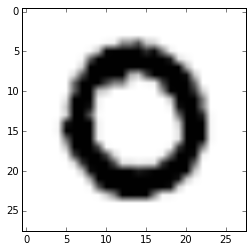

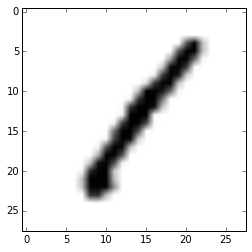

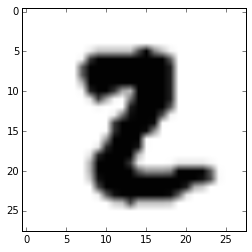

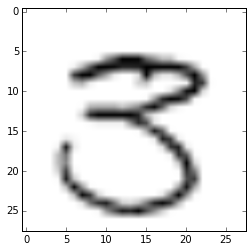

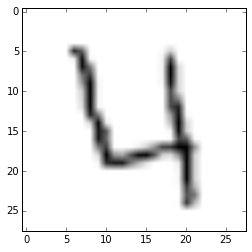

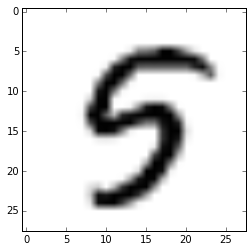

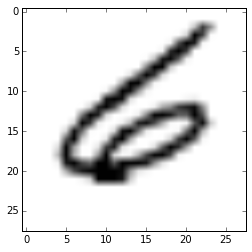

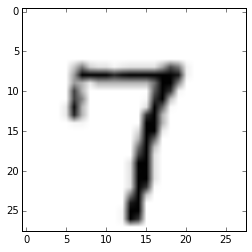

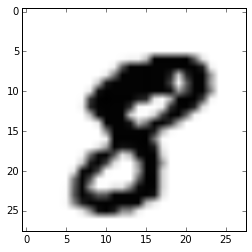

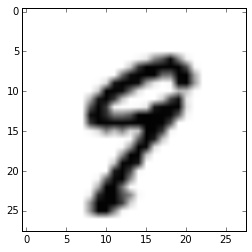

In [5]:
# Function displays digits
def showDigit(digit):
    plt.imshow(digit, cmap = cm.Greys)
    plt.show()
    
# Display each that were sampled
for digit in samples:
    showDigit(digit)

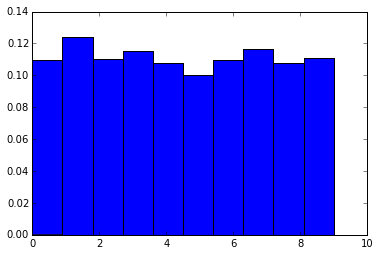

In [6]:
# df_train.sort('label').hist(kind='bar', normed=True)
digit_distribution = plt.hist(df_train.label, normed=True)

## C) Examining the distribution of digits in the dataset
The underlying distribution of digits is uniform though there aren't exactly the same number of digits.

## D) Computing Nearest Neighbhors for individual digits.

In [80]:
digit_list = [zeros, ones, twos, threes, fours, fives, sixs, sevens, eights, nines]
import numpy as np

def getNearest(theValue, anArrayOfValues): # Takes two NP arrays
    minimum = None
    for aValue in anArrayOfValues:
        aValue = aValue.reshape((28,28))

        distance = np.linalg.norm(theValue-aValue)
        if distance == 0: # Skip self
            continue

        if minimum is None:
            minimum = distance
        else:
            if minimum > distance:
                minimum = distance

    return minimum

def nearestComparison():
    min_per_digit = []
    for sample in range(0, 10):
        nearest_neighbor = None;
        for digit in range(0, 10):
            distance = getNearest(samples[sample], digit_list[digit].values)

            if nearest_neighbor is None:
                nearest_neighbor = {"digit": str(digit),"distance": getNearest(samples[sample], digit_list[digit].values)}

            if nearestNeighbor["distance"] > distance:
                nearest_neighbor = {"digit": str(digit),"distance": distance}

        min_per_digit.append(nearest_neighbor)
    return min_per_digit

In [49]:
nearest_results = nearestComparison()

In [57]:
#  Asterics highlights missmatch
for i in xrange(0, len(nearest_results)):
    if str(i) != nearest_results[i]["digit"]:
        print "Chosen digit " + str(i) + " has nearest neighbhor " + nearest_results[i]["digit"] + " *"
    else:
        print "Chosen digit " + str(i) + " has nearest neighbhor " + nearest_results[i]["digit"]

Chosen digit 0 has nearest neighbhor 0
Chosen digit 1 has nearest neighbhor 1
Chosen digit 2 has nearest neighbhor 2
Chosen digit 3 has nearest neighbhor 5 *
Chosen digit 4 has nearest neighbhor 4
Chosen digit 5 has nearest neighbhor 5
Chosen digit 6 has nearest neighbhor 6
Chosen digit 7 has nearest neighbhor 7
Chosen digit 8 has nearest neighbhor 8
Chosen digit 9 has nearest neighbhor 9


## E) Computing pairwise distances for 0s and 1s
For this part of the exercise we decided to parallelize the code in order to reduce the computation time. To do so we used iPython Parallel

<http://ipython.org/ipython-doc/dev/parallel/>

In [69]:
# Importing necessary libraries, establishing the engines and adding IDs to each engines to keep track of indexes.
# Must start a cluster. We used 4 cores.

from IPython import parallel
from scipy import stats, integrate, spatial
import pandas as pd
rc = parallel.Client()
lv = rc.load_balanced_view()
dview = rc[:]
engine_id = xrange(len(lv))
dview.scatter("engine_id", engine_id) # Pushes engine ID to the engine for reference
print len(lv)

4


In [70]:
# Pushing the data to each engine
dview.push({'df': df_train})
dview.push({"zeros": zeros.values, 
            "ones": ones.values, 
            "twos": twos.values, 
            "threes": threes.values, 
            "fours": fours.values, 
            "fives": fives.values, 
            "sixs": sixs.values, 
            "sevens": sevens.values, 
            "eights": eights.values, 
            "nines": nines.values})

<AsyncResult: _push>

In [71]:
# Breaking up the zeros and ones into equal batches and sending a batch to an engine
dview.scatter("scat_zeros", zeros.values)
dview.scatter("scat_ones", ones.values)

<AsyncResult: scatter>

+++ Note the magic function below simply distributes the following code accross the engines

In [72]:
%%px
# Adjusting the index of i relative to which block is being computed
# Cross checked that result is (n(n-1))/2
def getDistances(anArrayOfValues, otherArrayOfValues, indexAdjust):
    import numpy as np
    distances = []
    for i in xrange(len(anArrayOfValues)):
        for j in xrange(i+indexAdjust+1,len(otherArrayOfValues)):
            distances.append(np.linalg.norm(anArrayOfValues[i]-otherArrayOfValues[j]))
    return distances

# Cross checked that result is n^2
def getDistancesNoDups(anArrayOfValues, otherArrayOfValues, indexAdjust):
    import numpy as np
    distances = []
    for i in xrange(len(anArrayOfValues)):
        for j in xrange(i+indexAdjust,len(otherArrayOfValues)):
            distances.append(np.linalg.norm(anArrayOfValues[i]-otherArrayOfValues[j]))
    return distances

In [73]:
%%px 
zeros_distances = getDistances(scat_zeros, zeros, engine_id[0]*len(scat_zeros))
imposter_distances = getDistancesNoDups(scat_ones, zeros, engine_id[0]*len(scat_ones))
ones_distances = getDistances(scat_ones, ones, engine_id[0]*len(scat_ones))

#### For all distance computations
Without dupliactes 1 loops, best of 3: 1min 45s per loop 4Cores

#### For zero distances only
Without dupliactes 1 loops, best of 1: 25.9 s per loop 4Cores

Without duplicated 1 loops, best of 3: 28.7 s per loop 4Cores

With duplicated 1 loops, best of 3: 36.6 s per loop 4Cores

#### For ones only
Without duplicates 1 loops, best of 3: 34.5 s per loop 4Cores

In [74]:
legit_ones = dview.gather("ones_distances").get()
legit_zeros = dview.gather("zeros_distances").get()
imposter_distances = dview.gather("imposter_distances").get()

#### Gathering the distances
1 loops, best of 3: 1min 17s per loop

### Plotting the histograms for 1's vs the imposter pairs

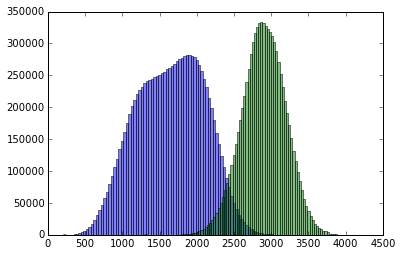

In [75]:
plt.hist(legit_ones, bins=100, alpha=.5, label="genuine")
plt.hist(imposter_distances, bins=100, alpha=.5, label="imposter")
plt.show()

### Plotting the histograms for 0's vs the imposter pairs

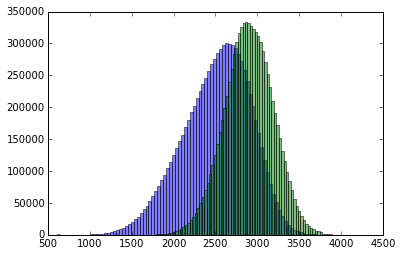

In [76]:
plt.hist(legit_zeros, bins=100, alpha=.5, label="genuine")
plt.hist(imposter_distances, bins=100, alpha=.5, label="imposter")
plt.show()

## F) Generating ROC curves for ones and zeros
The rate of a classifier which guesses randomly is equal to 0.5

In [77]:
# Sorting zeros, ones and imposters so that we do not have to iterate through the entire array for every rate
sortedLegitZeros = sorted(legit_zeros)
sortedLegitOnes = sorted(legit_ones)
sortedImposter = sorted(imposter_distances)

In [133]:
# Function returns a dictionary of rates
def calculateRates(legits, imposters, step): #sorted arrays
    import math
    Th = 0 #Threshold
    j_ind = 0
    i_ind = 0
    # Initial state of FTW
    Tp = 0.0
    Fp = 0.0
    Tn = len(imposters) - Fp
    Fn = len(legits) - Tp
    
    TPRs = []
    TNRs = []
    FPRs = []
    
    while Th < max(imposters[-1], legits[-1]) :
        for i in xrange(i_ind,len(legits)):
            if legits[i] <= Th:
                Tp += 1;
                Fn = len(legits) - Tp
                i_ind += 1
            else: 
                break
        for j in xrange(j_ind, len(imposters)):
            if imposters[j] < Th:
                Fp += 1;
                Tn = len(imposters) - Fp
                j_ind += 1
            else:
                break
        TPRs.append(1-float(Tp)/(Tp + Fn))
        TNRs.append(1 - float(Tn)/(Fp + Tn))
        FPRs.append(1-float(Fp)/(Fp + Tn))
        Th += step
    return ({"TPRs":TPRs,"TNRs":TNRs, "FPRs": FPRs})

In [130]:
rates_ones = calculateRates(sortedLegitOnes, sortedImposter, 100)
rates_zeros = calculateRates(sortedLegitZeros, sortedImposter, 100)

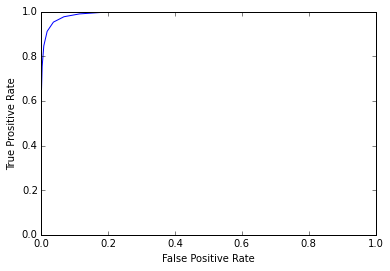

In [131]:
plt.figure()
plt.plot((rates_ones["TPRs"]), rates_ones["FPRs"])
plt.ylabel("True Prositive Rate")
plt.xlabel("False Positive Rate")
plt.show()

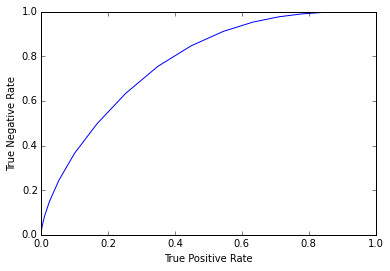

In [132]:
plt.figure()
plt.plot(rates_zeros["TPRs"], rates_zeros["FPRs"])
plt.ylabel("True Negative Rate")
plt.xlabel("True Positive Rate")
plt.show()

## G) Implementing a KN
In our implementation of nearest neighbor we compute all the distances between two datasets, find the k-nearest of the distances and then find the majority vote class for the smallest distances. We use the following libraries to ensure that the run time is reasonable.

###### scipy
We use scipy's cdist function to compute all the euclidean distances between two matrices. This implementation is incredibly speedy drastically reducing the time to compute our predictions.

cdist: http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html

###### numpy
We use numpy's ND array to facilitate matrix/vector operations which are implemented incredibly efficiently in this library. We also use numpy's argsort which finds the index of the minimums of a vector

Argsort: <http://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html>

In [7]:
def findDistances(test, train): #Takes a DF with Label
    from scipy import spatial
    distances = spatial.distance.cdist(test, train)   
    return distances

In [8]:
def findNearsIdxs(distances): #Matrix of distances
    mins = distances.argsort(axis=1)
    return mins

In [9]:
def findKNears(labels, nears, k): #make sure you have label values
    accessed = [labels[x] for x in nears[:,0:k]]
    return accessed

In [10]:
def findPrediction(kNears):
    from scipy import stats
    import random
    predictions = []

    for result in kNears:
        mode = stats.mode(result)
        predictions.append(random.choice(mode[0]))
    return predictions


#### Above we are implementing the functions required for KNN
#### Below we are implementing KNN

In [11]:
def kNN(test, train, labels, k):
    distances = findDistances(test, train)
    min_indexes = findNearsIdxs(distances)
    assessed = findKNears(labels, min_indexes, k)
    predictions = findPrediction(assessed)
    return predictions

In [12]:
def kNNWithDistances(distances, labels, k):
    min_indexes = findNearsIdxs(distances)
    assessed = findKNears(labels, min_indexes, k)
    predictions = findPrediction(assessed)
    return predictions
#     return assessed

In [31]:
# Since computing distances is the longest operation we are computing them here for train train and test train
train_train_distances = findDistances(df_train.drop("label",1), df_train.drop("label",1))

In [32]:
test_train_distances = findDistances(df_test.values, df_train.drop("label",1).values)

## H) 3 Fold 
In our implementation of 3-fold cross validation we split our dataset into three folds, then compute knn on 1, 2+3 | 2, 1+3 | 3, 1+2. We then generate a truth comparison of the label and the predicted value. 

In [33]:
labels = df_train.label.values
def makeThreeFolds(distanceMatrix):
    size = len(distanceMatrix)
    first = distanceMatrix[0:size/3, size/3:size]
    second = np.append(distanceMatrix[size/3:2*size/3, 0:size/3], 
                       distanceMatrix[size/3:2*size/3, 2*size/3:size],
                      axis=1)
    third = distanceMatrix[2*size/3:size, 0:2*size/3]
    
    return [first, second, third]

In [69]:
import numpy as np
size = len(df_train.drop("label",1))/3
size

14000

In [71]:
results_fold_one = kNN(df_train.drop("label",1).values[0:size], df_train.drop("label",1).values[size:], labels[size:], 5)

In [88]:
results_fold_two = kNN(df_train.drop("label",1)[size:2*size], df_train.drop("label",1)[size:], np.append(labels[0:size], labels[size*2:]), 5)

In [73]:
results_fold_three = kNN(df_train.drop("label",1)[2*size:], df_train.drop("label",1)[0:2*size], labels[:2*size], 5)

In [95]:
def createMatrix(truth):
    import numpy as np
    import pandas as pd
    confusion_matrix = np.zeros((10,10))
    for comparison in truth:
        confusion_matrix[comparison["actual"]][comparison["predicted"]] += 1
        # rows are the actual and columns are hte predicted
    return pd.DataFrame(confusion_matrix)

createMatrix(fold_two_truth)



,0,1,2,3,4,5,6,7,8,9
0,1179,35,14,20,19,17,11,24,16,15
1,94,1260,28,23,26,13,15,35,17,21
2,123,132,957,23,21,29,29,41,18,24
3,86,83,91,1078,28,38,23,26,25,21
4,94,121,68,45,930,9,23,25,21,52
5,124,82,39,70,32,778,47,29,13,31
6,83,89,67,38,31,42,958,20,23,29
7,114,115,57,43,50,33,29,976,27,16
8,120,126,69,71,36,34,42,23,807,23
9,111,118,64,57,56,38,34,40,30,850


In [90]:
def getTruth(test_labels, results):
    truth = []
    for i in xrange(min(len(test_labels), len(results_fold_one))):
        truth.append({"actual": test_labels[i], "predicted": results[i]})

    return truth

fold_one_truth = getTruth(labels[0:size], results_fold_one)
fold_two_truth = getTruth(labels[size:2*size], results_fold_two)
fold_three_truth = getTruth(labels[2*size:], results_fold_three)

In [49]:
df_train.drop("label",1).values[0:size]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [83]:
result_all = kNNWithDistances(train_train_distances, labels, 5)

In [84]:
result_test = kNNWithDistances(test_train_distances, labels, 5)

In [97]:
result_all_truth = getTruth(labels, result_all)

In [99]:
createMatrix(result_all_truth)

,0,1,2,3,4,5,6,7,8,9
0,1361,1,1,0,0,2,6,0,0,0
1,0,1570,1,1,0,0,0,1,1,1
2,5,11,1394,1,0,0,0,15,0,1
3,0,2,6,1384,1,7,0,3,4,3
4,0,12,0,0,1341,0,2,0,0,13
5,3,0,1,8,0,1253,8,0,1,2
6,4,2,0,0,2,3,1388,0,0,0
7,0,13,4,0,3,0,0,1434,0,10
8,5,10,2,13,1,16,6,2,1280,8
9,3,1,0,4,10,3,2,11,1,1332
